
"Modeling Melburnians - Using the Koopman operator to gain insight into crowd dynamics"
============================================================

Spplementary material 
--------------------------------

Authors: Daniel Lehmberg, Felix Dietrich, Gerta Köster


This file reproduces results and shows the figures contained in the paper. The training of the EDMD model and plotting is contained in ``main.py``.  

In [1]:
import numpy as np
import pandas as pd
from datafold.pcfold import TSCDataFrame
from sklearn.model_selection import train_test_split

import main

# Set cache flag

Enable to read cached csv data. All cache files listed (see file descriptions in README.rst) must be available in the repository. 

If ``use_cache=False`` this creates new ``.csv``-cache files or overwrites the existing files.

In [2]:
use_cache = True 

# Prepare data

* Read raw data
* Select sensors from available data 
* Split data in training and test set

In [3]:
if use_cache:
    X = TSCDataFrame.from_csv("X_selected.csv", parse_dates=True)
else:
    X = main.read_and_select_data("X_all.csv")
    X.to_csv("X_selected.csv")

train_time_values, test_time_values = train_test_split(
        X.index.get_level_values("time"),
        train_size=2 / 3.0,
        shuffle=False,
)

train_sensor_data = X.loc[pd.IndexSlice[:, train_time_values], :]
test_sensor_data = X.loc[pd.IndexSlice[:, test_time_values], :]

n_samples_ic = 168+1  # 168 time delays + 1 for the current state

train_sensor_data = main.filter_data(
    X=train_sensor_data,
    start_time=0,
    n_samples_ic=n_samples_ic,
    min_timesteps=2 * n_samples_ic,
)

test_sensor_data = main.filter_data(
    X=test_sensor_data,
    start_time=0,
    n_samples_ic=n_samples_ic,
    min_timesteps=2 * n_samples_ic,
)

print(f"Total n_samples: {train_sensor_data.shape[0] + test_sensor_data.shape[0]}")
print(f"Total samples train: {train_sensor_data.shape[0]}")
print(f"Total samples test: {test_sensor_data.shape[0]}")
print(f"Total time series: {train_sensor_data.n_timeseries + test_sensor_data.n_timeseries}"
)
print(f"Time series train: {train_sensor_data.n_timeseries}")
print(f"Time series test: {test_sensor_data.n_timeseries}")

Total n_samples: 28970
Total samples train: 19130
Total samples test: 9840
Total time series: 34
Time series train: 22
Time series test: 12


### Data snippet

In [4]:
test_sensor_data.head(5).astype(int)

feature                 sensor_2_counts  sensor_6_counts  sensor_9_counts  \
ID time                                                                     
0  2018-09-01 00:00:00              227              647               49   
   2018-09-01 01:00:00              170              364               32   
   2018-09-01 02:00:00               95              304               15   
   2018-09-01 03:00:00               55              254               32   
   2018-09-01 04:00:00               33              206                7   

feature                 sensor_10_counts  sensor_18_counts  sensor_21_counts  \
ID time                                                                        
0  2018-09-01 00:00:00                27                45               746   
   2018-09-01 01:00:00                17                36               551   
   2018-09-01 02:00:00                 4                12               434   
   2018-09-01 03:00:00                10                13               314   
   2018-09-01 04:00:00                 3                 6               230   

feature                 sensor_24_counts  sensor_26_counts  sensor_27_counts  \
ID time                                                                        
0  2018-09-01 00:00:00               317               211                44   
   2018-09-01 01:00:00               210               193                34   
   2018-09-01 02:00:00               149               164                28   
   2018-09-01 03:00:00                58                90                10   
   2018-09-01 04:00:00                59               100                10   

feature                 sensor_28_counts  sensor_31_counts  
ID time                                                     
0  2018-09-01 00:00:00               570               192  
   2018-09-01 01:00:00               429                71  
   2018-09-01 02:00:00               224                28  
   2018-09-01 03:00:00               219                13  
   2018-09-01 04:00:00               156                 7

## Plot sensor data

The blue part corresponds to the training data and the red part to the chronologically separated test time series. The first 193 samples of each series in black are required to perform the time delay embedding. 

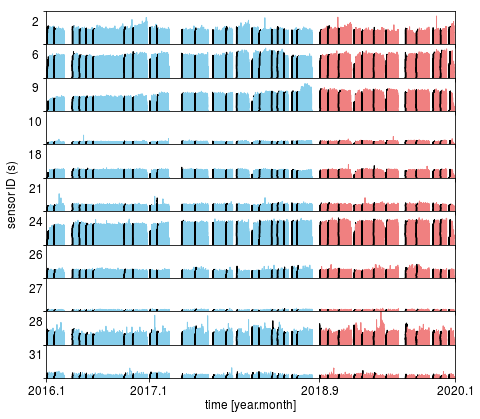

In [5]:
main.plot_paper_data(train_sensor_data, test_sensor_data, n_samples_ic)

# Set up and fit model

The EDMD model is fit every time, even when cache is enabled. This can take a while.

In [6]:
edmd, n_samples_ic = main.setup_basic_edmd()
edmd.fit(train_sensor_data, {"dmd__store_system_matrix": True});

Model: 
 EDMDPositiveSensors(dict_steps=[('takens', TSCTakensEmbedding(delays=168)),
                                ('laplace',
                                 DiffusionMaps(dist_kwargs={'cut_off': inf},
                                               kernel=GaussianKernel(epsilon=median(Distance)*1.0),
                                               n_eigenpairs=500))],
                    dmd_model=DMDFull(is_diagonalize=True),
                    include_id_state=False, sort_koopman_triplets=True,
                    verbose=True)
[Pipeline] ............ (step 1 of 3) Processing takens, total=   0.4s
[Pipeline] ........... (step 2 of 3) Processing laplace, total=13.4min
[Pipeline] ............... (step 3 of 3) Processing dmd, total=   1.7s


# Reconstruct data


If `use_cache=False` the model computes the data again and overwrites existing cache in the .csv file (this may take a while).

### Reconstruct training data

In [7]:
if not use_cache:
    (
        X_reconstruct_train,
        X_windows_train,
        X_latent_train,
        X_latent_interp_train,
        X_eigfunc_train,
    ) = main.reconstruct_prediction_horizon(
        edmd, train_sensor_data, prefix="train", interp_min_values=None
    )
    # store cache files 
    X_reconstruct_train.to_csv("X_reconstruct_train.csv")
    X_windows_train.to_csv("X_windows_train.csv")
    X_latent_train.to_csv("X_latent_train.csv")
else:
    X_reconstruct_train = TSCDataFrame.from_csv(
        "X_reconstruct_train.csv", parse_dates=True
    )
    X_windows_train = TSCDataFrame.from_csv("X_windows_train.csv", parse_dates=True)
    X_latent_train = TSCDataFrame.from_csv("X_latent_train.csv", parse_dates=True)

In [8]:
X_windows_train.n_timesteps

193

### Reconstruct test data

In [9]:
if not use_cache:
    (
        X_reconstruct_test,
        X_windows_test,
        X_latent_test,
        X_latent_interp_test,
        X_eigfunc_test,
    ) = main.reconstruct_prediction_horizon(
        edmd, test_sensor_data, prefix="test", interp_min_values=30
    )

    X_reconstruct_test.to_csv("X_reconstruct_test.csv")
    X_windows_test.to_csv("X_windows_test.csv")
    X_latent_test.to_csv("X_latent_test.csv")
    X_latent_interp_test.to_csv("X_latent_interp_test.csv")
    X_eigfunc_test.to_csv("X_eigfunc_test.csv")

else:
    X_reconstruct_test = TSCDataFrame.from_csv("X_reconstruct_test.csv", parse_dates=True)
    X_windows_test = TSCDataFrame.from_csv("X_windows_test.csv", parse_dates=True)
    X_latent_test = TSCDataFrame.from_csv("X_latent_test.csv", parse_dates=True)
    X_latent_interp_test = TSCDataFrame.from_csv("X_latent_interp_test.csv", parse_dates=True)
    
    # pandas does not read complex values from csv
    # https://github.com/pandas-dev/pandas/issues/9379
    # first read strings and then cast to complex values
    X_eigfunc_test = pd.read_csv("X_eigfunc_test.csv", index_col=[0, 1], header=[0], parse_dates=True)
    X_eigfunc_test = TSCDataFrame(X_eigfunc_test.astype(complex))

# Model analysis

## Example week of time series

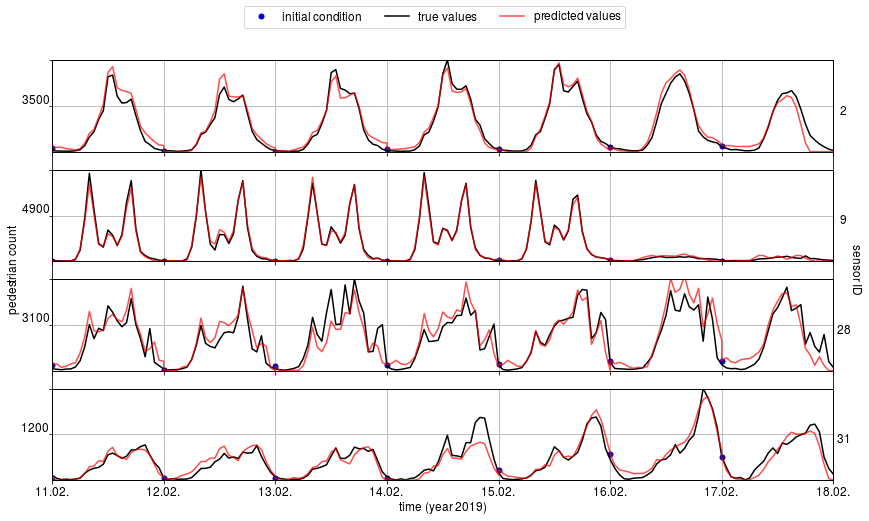

In [10]:
main.plot_paper_week_timeseries(
    X_windows_test=X_windows_test, X_reconstruct_test=X_reconstruct_test
)

## Plot reconstruction of sensor test data

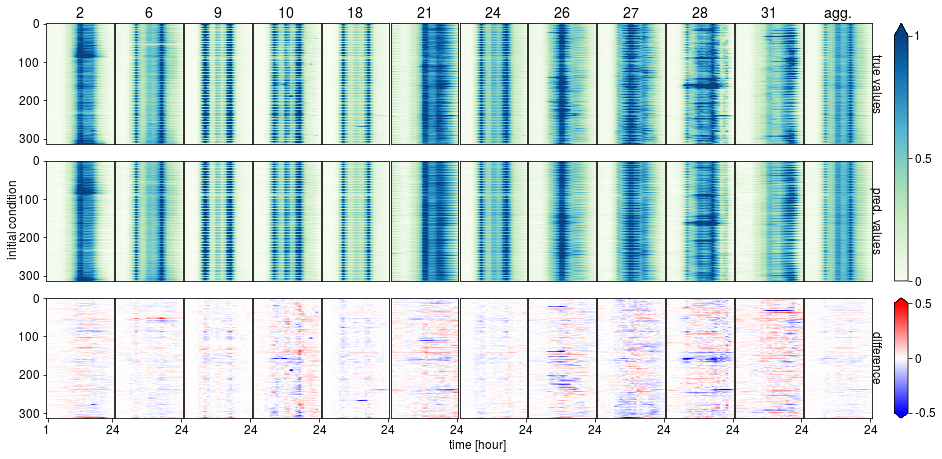

In [11]:
scale = main.scale_sensors(X_windows=X_windows_train.loc[X_reconstruct_train.index, :])

main.plot_paper_sensor_profile(
    scale=scale,
    X_windows_test=X_windows_test,
    X_reconstruct_test=X_reconstruct_test,
)

## Show error measures of table 

In [12]:
df = main.plot_error_table(
    edmd=edmd,
    X_windows_train=X_windows_train,
    X_reconstruct_train=X_reconstruct_train,
    X_windows_test=X_windows_test,
    X_reconstruct_test=X_reconstruct_test,
)
df


MER on entire test set 16.982043558548757
EDMD score train = -0.031872316753674884
Naive score train = -0.0424159313376079
EDMD score test = -0.03906084158923439
Naive score test = -0.04684109289588103


training ($C_{\text{train}} = 622$)            \
   ID ($s$) $Q_{95\%}$                      mean $\pm$ std     RRMSE   
0         2       3116                        -8 $\pm$ 198   6.36 \%   
1         6       4048                        -3 $\pm$ 199   4.91 \%   
2         9       2805                        -2 $\pm$ 103   3.68 \%   
3        10        592                          0 $\pm$ 48   8.11 \%   
4        18       1540                         -1 $\pm$ 53   3.47 \%   
5        21       1410                        -2 $\pm$ 118    8.4 \%   
6        24       3970                        -2 $\pm$ 138   3.48 \%   
7        26       1629                        -1 $\pm$ 109   6.69 \%   
8        27        339                          0 $\pm$ 30   8.98 \%   
9        28       2662                        -4 $\pm$ 293  11.01 \%   
10       31        719                         -2 $\pm$ 81  11.33 \%   
11     agg.                                   -3 $\pm$ 171   6.95 \%   

             test ($C_{\text{test}} = 314$)                      
    RRMSE(b)                 mean $\pm$ std     RRMSE  RRMSE(b)  
0    8.69 \%                  -11 $\pm$ 204   6.55 \%   7.06 \%  
1    6.82 \%                    1 $\pm$ 254   6.28 \%   8.03 \%  
2    4.54 \%                   -6 $\pm$ 146    5.2 \%   5.83 \%  
3   10.34 \%                    -4 $\pm$ 57   9.62 \%  11.46 \%  
4    4.25 \%                     6 $\pm$ 74   4.81 \%    5.5 \%  
5   11.82 \%                   -9 $\pm$ 130   9.27 \%  11.51 \%  
6    4.65 \%                    8 $\pm$ 170   4.29 \%   5.11 \%  
7    8.24 \%                    4 $\pm$ 168  10.29 \%  12.08 \%  
8   11.64 \%                     4 $\pm$ 35   10.3 \%  11.88 \%  
9   16.25 \%                    1 $\pm$ 350  13.16 \%  17.99 \%  
10  14.57 \%                   -10 $\pm$ 95  13.26 \%   15.7 \%  
11   9.26 \%                   -1 $\pm$ 207   8.46 \%   10.2 \%

## Plot diffusion map coordinates on time-delayed data (dictionary of EDMD) 

#### Plot paper selection

Smallest DMAP eigenvalue = 1.6578957833468522e-05


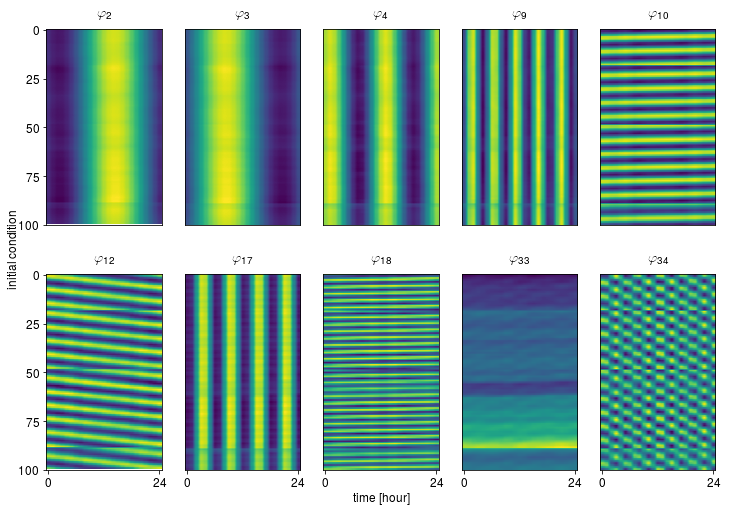

In [13]:
main.plot_paper_dmap_selection(
    edmd,
    selection = np.array([1, 2, 3, 8, 9, 11, 16, 17, 32, 33]),
    X_latent_test=X_latent_test,
)

#### Plot 40 first diffusion maps

Smallest DMAP eigenvalue = 1.6578957833468522e-05


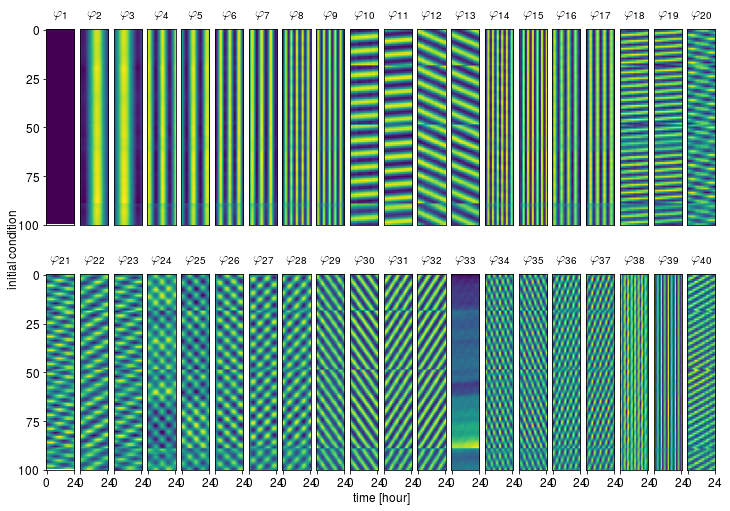

In [14]:
main.plot_paper_dmap_selection(
    edmd,
    selection = np.arange(40),
    X_latent_test=X_latent_test,
)

## Plot saisonal diffusion map time series

This plot is not included in the paper.

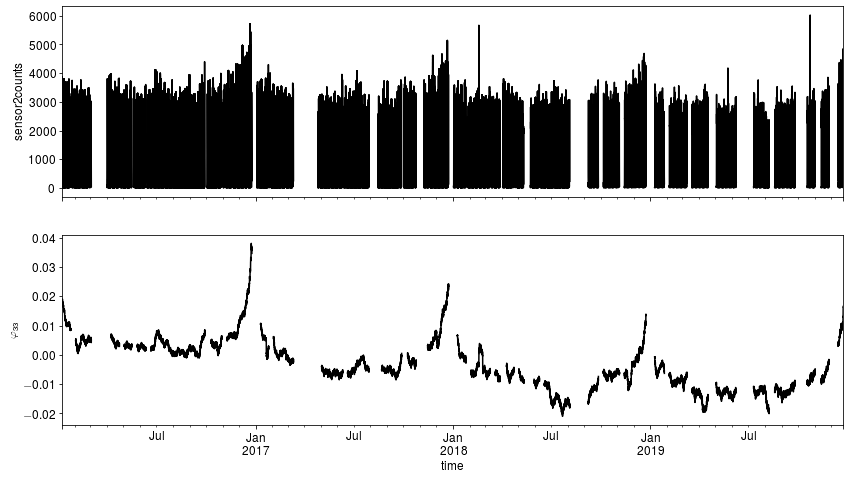

In [15]:
main.plot_timeseries_dmap(
    sensor_str="sensor_2_counts",
    dmap_idx=33,
    X_windows_train=X_windows_train,
    X_windows_test=X_windows_test.loc[X_reconstruct_test.index, :],
    X_latent_train=X_latent_train,
    X_latent_test=X_latent_test,
)

## Koopman eigenpairs

### Koopman eigenvalues

Largest Koopman eigenvalue 1.0005339100598134


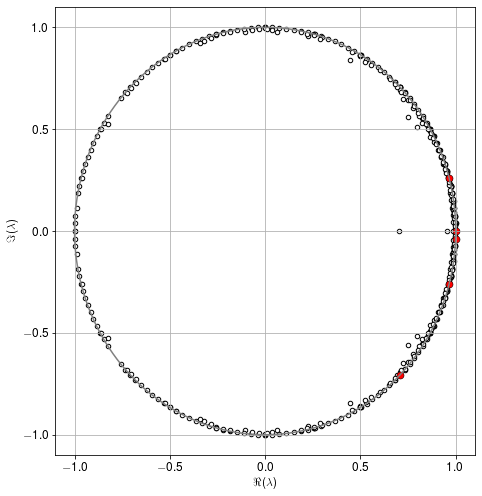

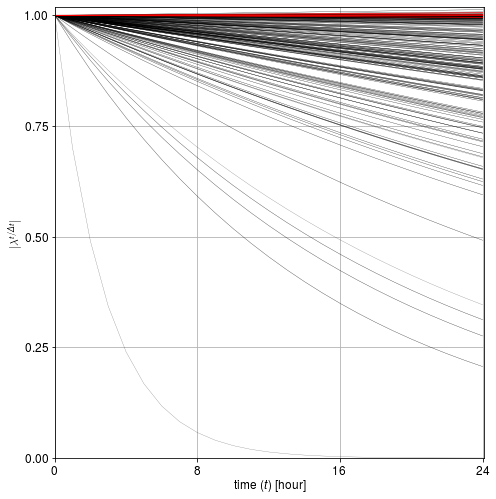

In [16]:
paper_selection = np.array([1, 4, 6, 8, 14]) # set in "select_plot" parameter below to obtain paper selection 

main.plot_paper_koop_eigval(
    edmd=edmd,
    select_plot=paper_selection,
)

### Koopman eigenfunctions
##### Plot paper selection

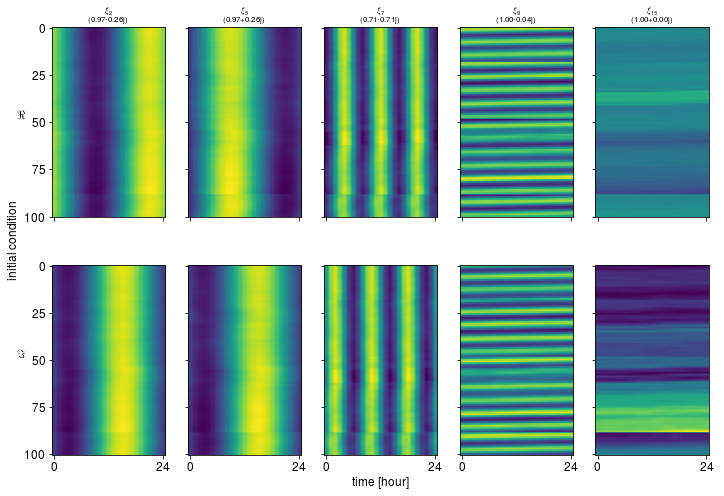

In [17]:
main.plot_paper_koop_eigfunc(
    edmd=edmd,
    selection=paper_selection,
    X_eigfunc_test=X_eigfunc_test,
)

##### Plot first 20 Koopman eigenfunctions 

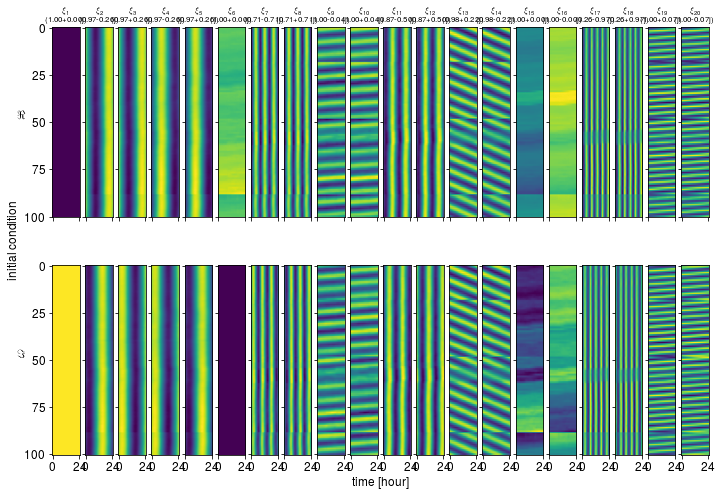

In [18]:
main.plot_paper_koop_eigfunc(
    edmd=edmd,
    selection=np.arange(20),
    X_eigfunc_test=X_eigfunc_test,
)